In [3]:
import pandas as pd
import math
from google.cloud import storage


In [4]:
client = storage.Client(project="uk-election-406413")
bucket = client.bucket("ukelectiondata")
files = bucket.list_blobs()
file_names = [file.name for file in files]


In [5]:
election_results = bucket.blob("full_df.csv")
election_results.download_to_filename('C:\\Users\\wg4618\\Documents\\LeWagon\\full_data.csv')


# Preparing Data

In [6]:
data = pd.read_csv('C:\\Users\\wg4618\\Documents\\LeWagon\\full_data.csv')
data.drop(data.columns[0], axis=1, inplace=True)
data.dropna(subset=['Cons_pre_GE_adjusted'], inplace=True)

data_raw = data[data['year'] != 2024].drop(columns="year")
data_new_raw = data[data['year'] == 2024].drop(columns="year")


X = data_raw[['Private_renters', 'Social_renters', 'Home_owners',
          '0-9', '10-19',
          '20-29', '30-39', '40-49', '50-59',
          '60-69', '70-79', '80+',
          'Asian', 'Black', 'Mixed', 'Other', 'White',
          #'conservative_vote_share_previous', 'labour_vote_share_previous',# 'liberal_democrats_vote_share_previous',
          #'Conservative_Pre_GE_poll', 'Labour_Pre_GE_poll', 'LD_Pre_GE_poll',
          'Cons_pre_GE_adjusted', 'Labs_pre_GE_adjusted', 'Libs_pre_GE_adjusted',
          'Cons_pre_average_adjusted', 'Labs_pre_average_adjusted', 'Libs_pre_average_adjusted',
          #'Conservative_min', 'Labour_min', 'LD_min',
          #'Conservative_max', 'Labour_max', 'LD_max'
          ]]

X_new = data_new_raw[['Private_renters', 'Social_renters', 'Home_owners',
          '0-9', '10-19',
          '20-29', '30-39', '40-49', '50-59',
          '60-69', '70-79', '80+',
          'Asian', 'Black', 'Mixed', 'Other', 'White',
          #'conservative_vote_share_previous', 'labour_vote_share_previous', #'liberal_democrats_vote_share_previous',
          #'Conservative_Pre_GE_poll', 'Labour_Pre_GE_poll', 'LD_Pre_GE_poll',
          'Cons_pre_GE_adjusted', 'Labs_pre_GE_adjusted', 'Libs_pre_GE_adjusted',
          'Cons_pre_average_adjusted', 'Labs_pre_average_adjusted', 'Libs_pre_average_adjusted',
          #'Conservative_min', 'Labour_min', 'LD_min',
          #'Conservative_max', 'Labour_max', 'LD_max'
          ]]

#X_new['Libs_pre_GE_adjusted'] = X_new['Libs_pre_GE_adjusted']*2

y = data_raw[['conservative_votes', 'labour_votes', 'liberal_democrats_votes']]#, 'other_parties_votes']]


In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
#data.columns


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from pandas.plotting import scatter_matrix
import seaborn as sns

# Create scatter matrix
#scatter_matrix(data_plot[columns_for_scatter], figsize=(10, 8), alpha=0.8, c=data_plot[target_column], cmap='viridis')
#data[data["conservative_votes"]==0]
#sns.scatterplot(data_plot2['conservative_votes'], y=data_plot['Cons_pre_GE_adjusted'])
#sns.boxplot(x=round(data_plot['Labour_Pre_GE_poll'],3), y=data_plot['conservative_votes'], data=data_plot)


# Ridge Regression Model

### Grid search

In [10]:
# Create and fit a Linear Regression model
alphas = {'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1]}

ridge = Ridge()
grid_search = GridSearchCV(ridge, alphas, cv=5)
grid_search.fit(X_train, y_train)
display(grid_search.cv_results_['mean_test_score'])

X_train.columns


array([0.83450173, 0.83506169, 0.83519964, 0.83513591, 0.83515561,
       0.83488169, 0.82995635])

Index(['Private_renters', 'Social_renters', 'Home_owners', '0-9', '10-19',
       '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'Asian',
       'Black', 'Mixed', 'Other', 'White', 'Cons_pre_GE_adjusted',
       'Labs_pre_GE_adjusted', 'Libs_pre_GE_adjusted',
       'Cons_pre_average_adjusted', 'Labs_pre_average_adjusted',
       'Libs_pre_average_adjusted'],
      dtype='object')

### Running and scoring the best model

In [11]:
best_alpha = grid_search.best_params_['alpha']
print("Best alpha: ", best_alpha)

final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coefficients:", final_model.coef_)
print("Intercept:", final_model.intercept_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

coefficients_named = pd.DataFrame({"con" : final_model.coef_[0],
                                   "lab" : final_model.coef_[1],
                                   "ld" : final_model.coef_[2],
                                   }, index=X_train.columns)
display(final_model.intercept_)
display(coefficients_named)


Best alpha:  1e-05
Coefficients: [[-2.32668527e+03 -4.25186072e+03  6.57854599e+03 -2.02829611e+04
  -1.10050122e+04 -2.28658265e+04  2.01521106e+04 -5.42289106e+04
   3.96372337e+04 -1.07778117e+05  9.79742930e+04 -1.17593858e+05
   7.39057657e+03  1.26101983e+04 -7.61364847e+03 -1.97988886e+04
   7.40691897e+03  1.89111646e+04 -1.18074207e+04 -1.30856333e+04
   2.80167969e+04  1.94382306e+03  1.94146696e+04]
 [ 6.59853133e+03 -8.90102158e+03  2.30249031e+03 -2.11101699e+05
  -3.36772646e+04 -1.05016358e+05 -3.54867532e+04 -8.70091786e+04
  -1.23037820e+05 -4.21087766e+04 -1.75433133e+05 -8.23482306e+04
   6.03774239e+03  1.31956001e+04  2.70543141e+04 -4.36536439e+04
  -2.61818079e+03  6.78600127e+04  5.43439843e+04  5.78313853e+03
  -7.27159174e+04 -1.42673007e+04 -1.29824726e+04]
 [ 1.61731550e+03  2.64708032e+02 -1.88202351e+03  2.53039982e+05
   3.58218114e+05  2.86276089e+05  3.30739815e+05  3.48361800e+05
   2.76509675e+05  3.03008343e+05  2.61869992e+05  3.57973494e+05
  -6.50

array([  11688.07326894,  104369.38211401, -301893.68242988])

,con,lab,ld
Private_renters,-2326.685270,6598.531334,1617.315502
Social_renters,-4251.860715,-8901.021582,264.708032
Home_owners,6578.545993,2302.490311,-1882.023511
0-9,-20282.961111,-211101.699326,253039.981963
10-19,-11005.012214,-33677.264602,358218.114189
20-29,-22865.826494,-105016.358231,286276.088743
30-39,20152.110565,-35486.753227,330739.814799
40-49,-54228.910595,-87009.178580,348361.800160
50-59,39637.233694,-123037.819717,276509.675037
60-69,-107778.116535,-42108.776584,303008.343221


### Plotting the test data against the predicted data

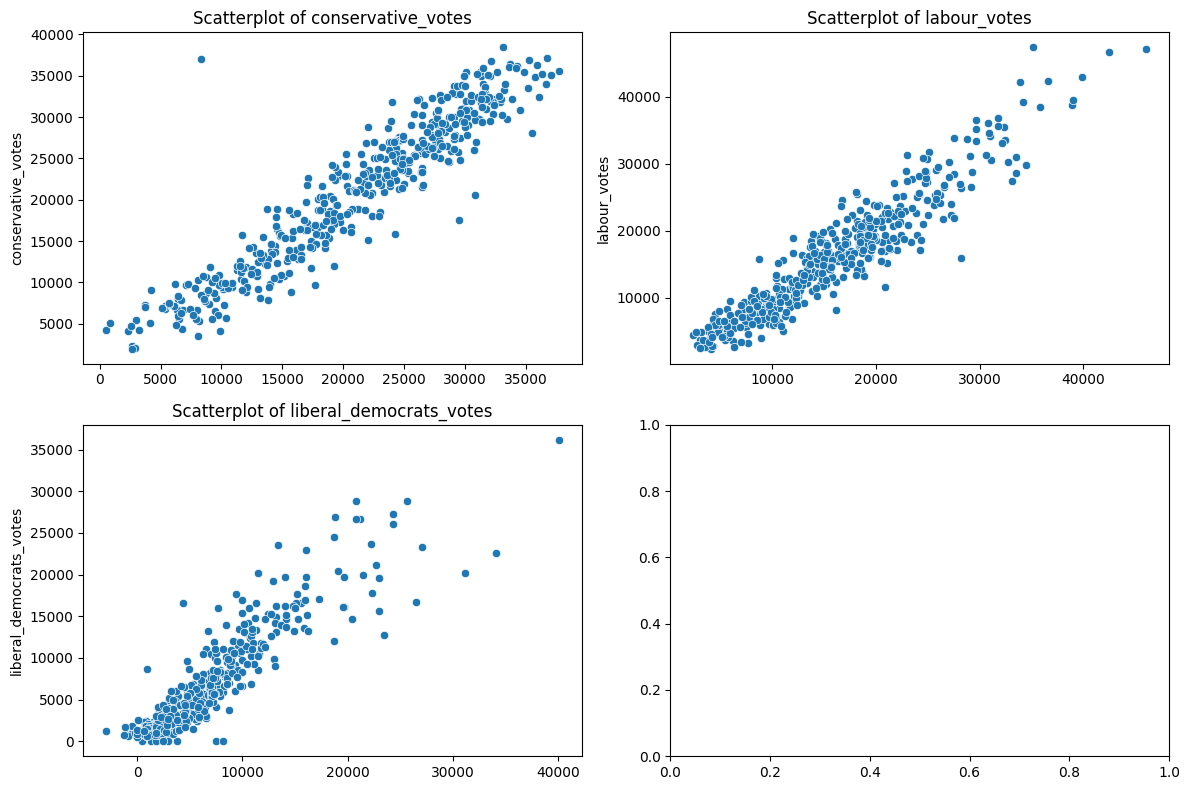

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over columns and create subplots
for i in range(3):
    sns.scatterplot(x=y_pred[:,i], y=y_test.iloc[:,i], ax=axes[i])
    axes[i].set_title(f'Scatterplot of {y_test.columns[i]}')

# Adjust layout
plt.tight_layout()

# Show the plots
#plt.show()


### Predicting the next election using Ridge Regression

In [13]:
final_model.predict(X_new)
X_new


,Private_renters,Social_renters,Home_owners,0-9,10-19,20-29,30-39,40-49,50-59,60-69,...,Black,Mixed,Other,White,Cons_pre_GE_adjusted,Labs_pre_GE_adjusted,Libs_pre_GE_adjusted,Cons_pre_average_adjusted,Labs_pre_average_adjusted,Libs_pre_average_adjusted
4,0.113468,0.203506,0.683026,0.110,0.117,0.121,0.133,0.122,0.137,0.120,...,0.002964,0.007334,0.001331,0.975867,0.118038,0.677309,0.032447,0.162275,0.595796,0.027222
9,0.165503,0.121423,0.713075,0.094,0.098,0.098,0.103,0.108,0.151,0.140,...,0.001719,0.008402,0.002712,0.978375,0.263746,0.499658,0.054656,0.362590,0.439525,0.045855
14,0.172328,0.156583,0.671090,0.129,0.111,0.118,0.150,0.143,0.142,0.094,...,0.019293,0.021343,0.006293,0.855334,0.334032,0.296179,0.138078,0.459218,0.260534,0.115843
19,0.083391,0.147883,0.768726,0.109,0.110,0.105,0.113,0.120,0.151,0.113,...,0.009705,0.015525,0.003118,0.931288,0.405074,0.256322,0.057639,0.556885,0.225474,0.048358
24,0.121427,0.124764,0.753809,0.127,0.134,0.085,0.121,0.149,0.140,0.102,...,0.009763,0.021306,0.008696,0.904339,0.274926,0.463506,0.105416,0.377961,0.407723,0.088441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2831,0.140180,0.337258,0.522561,0.148,0.115,0.114,0.164,0.128,0.127,0.094,...,0.028443,0.032815,0.011704,0.871232,0.172067,0.670644,0.066476,0.236554,0.589933,0.055771
2836,0.141064,0.154904,0.704032,0.110,0.105,0.100,0.118,0.115,0.142,0.126,...,0.002500,0.007529,0.001236,0.978433,0.333987,0.079861,0.297075,0.459157,0.070250,0.249237
2841,0.145188,0.150661,0.704150,0.104,0.104,0.098,0.104,0.112,0.142,0.144,...,0.001161,0.006882,0.002566,0.982352,0.202874,0.378372,0.000000,0.278906,0.332836,0.000000
2846,0.264085,0.193474,0.542441,0.094,0.103,0.255,0.148,0.108,0.109,0.080,...,0.008279,0.014565,0.006880,0.927328,0.159132,0.694221,0.080157,0.218770,0.610672,0.067249


In [14]:
import numpy as np
y_new = final_model.predict(X_new)

unique_values, counts = np.unique(np.argmax(y_new, axis=1), return_counts=True)
frequency_table = pd.DataFrame({'Value': unique_values, 'Frequency': counts})

frequency_table


,Value,Frequency
0,0,340
1,1,228
2,2,5


# Gradient Boosting Classifier

### Turning y into a class and encoding it

In [15]:
from sklearn.preprocessing import LabelEncoder

y_train_class = y_train.apply(lambda row: row.idxmax(), axis=1)
y_test_class = y_test.apply(lambda row: row.idxmax(), axis=1)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_class)
y_test_encoded = label_encoder.fit_transform(y_test_class)


### Grid Search 

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

gb_classifier = GradientBoostingClassifier()

param_grid = {'n_estimators': [100],
    'learning_rate': [0.01],
    'max_depth': [5]}

grid_search_tree = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, scoring='f1_macro', cv=5)

grid_search_tree.fit(X_train, y_train_encoded)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01], 'max_depth': [5],
                         'n_estimators': [100]},
             scoring='f1_macro')

### Running and scoring the best model

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Best Hyperparameters:", grid_search_tree.best_params_)

best_model_gb = grid_search_tree.best_estimator_
best_model_gb.fit(X_train, y_train_encoded)
y_pred_tree = best_model_gb.predict(X_test)

classification_rep = classification_report(y_test_encoded, y_pred_tree)
print("Classification Report:\n", classification_rep)


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       273
           1       0.93      0.90      0.91       167
           2       0.50      0.25      0.33        16

    accuracy                           0.91       456
   macro avg       0.78      0.70      0.73       456
weighted avg       0.90      0.91      0.90       456



### Predicting the next election using Boosted Tree

In [18]:
y_new_tree = best_model_gb.predict(X_new)

unique_values, counts = np.unique(y_new_tree, return_counts=True)

frequency_table = np.column_stack((unique_values, counts))

unique_values, counts = np.unique(y_new_tree, return_counts=True)
frequency_table = pd.DataFrame({'Value': unique_values, 'Frequency': counts})

frequency_table


,Value,Frequency
0,0,298
1,1,270
2,2,5


# K Nearest Neighbours

### Grid search

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn_classifier = KNeighborsClassifier()  # You can adjust the number of neighbors (k) as needed

param_grid_knn = {'n_neighbors': [3,4,5,6,7,8]}

grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid_knn, scoring='f1_macro', cv=5)

# Fit the model to the training data
grid_search_knn.fit(X_train, y_train_encoded)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8]},
             scoring='f1_macro')

### Running and scoring the best model

In [20]:
# Make predictions on the test set
best_model_knn = grid_search_knn.best_estimator_
best_model_knn.fit(X_train, y_train_encoded)
y_pred_knn = best_model_knn.predict(X_test)

classification_rep = classification_report(y_test_encoded, y_pred_knn)

print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       273
           1       0.90      0.87      0.89       167
           2       0.53      0.50      0.52        16

    accuracy                           0.89       456
   macro avg       0.78      0.77      0.77       456
weighted avg       0.89      0.89      0.89       456



### Predicting the next election using KNN

In [21]:
y_new_knn = best_model_knn.predict(X_new)

unique_values, counts = np.unique(y_new_knn, return_counts=True)

frequency_table = np.column_stack((unique_values, counts))

unique_values, counts = np.unique(y_new_knn, return_counts=True)
frequency_table = pd.DataFrame({'Value': unique_values, 'Frequency': counts})

frequency_table


,Value,Frequency
0,0,286
1,1,271
2,2,16


# SVC 

### Grid search

In [22]:
from sklearn.svm import SVC

svc_classifier = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],        # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto'],    # Kernel coefficient
}

grid_search_svc = GridSearchCV(estimator=svc_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search_svc.fit(X_train, y_train_encoded)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

### Running and scoring the best model

In [23]:
best_svc = grid_search_svc.best_estimator_

best_svc.fit(X_train, y_train_encoded)

y_pred_svc = best_svc.predict(X_test)

classification_rep = classification_report(y_test_encoded, y_pred_svc)

print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       273
           1       0.92      0.92      0.92       167
           2       0.54      0.44      0.48        16

    accuracy                           0.91       456
   macro avg       0.80      0.77      0.78       456
weighted avg       0.91      0.91      0.91       456



### Predicting the next election using SVC

In [24]:
y_new_SVC = best_svc.predict(X_new)

unique_values, counts = np.unique(y_new_SVC, return_counts=True)

frequency_table = np.column_stack((unique_values, counts))

unique_values, counts = np.unique(y_new_SVC, return_counts=True)
frequency_table = pd.DataFrame({'Value': unique_values, 'Frequency': counts})

frequency_table


,Value,Frequency
0,0,277
1,1,263
2,2,33
